In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! cp '/content/drive/MyDrive/data' '/' -r

In [ ]:
! rm /model -r
! mkdir /model

### Load Data

In [13]:
import pandas as pd
import torchtext
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time
import csv

In [18]:
fileNn = '/content/drive/MyDrive/APS360_project_group_12'

In [5]:
# funciton used to skip empty rows (51st - end) in new data

def skipFromHere(index):

    if index > 50:
        return True
    
    return False

In [19]:
def data_loader(batch_size=128):
    # load data from csv file
    fields = ['news_article', 'news_category']

    train_data = pd.read_csv(fileNn + '/content/inshort_news_data-train.csv', header=0, encoding='ISO-8859-1', usecols=fields, skip_blank_lines=True)
    val_data = pd.read_csv(fileNn +'/content/inshort_news_data-val.csv', header=0, encoding='ISO-8859-1', usecols=fields, skip_blank_lines=True)
    test_data = pd.read_csv(fileNn +'/content/inshort_news_data-test.csv', header=0, encoding='ISO-8859-1', usecols=fields, skip_blank_lines=True)
    new_data = pd.read_csv(fileNn +'/content/new_news_articles.csv',header=0, encoding='ISO-8859-1', usecols=fields, skip_blank_lines=True, skiprows=lambda x: skipFromHere(x))
    # read_csv seems have bugs for skip_blank_lines accoring to return value of what i tried for 
    # new_data before and online forum, so i use skirows instead of skip_blank_lines


    # Creating training and testing data
    X_train = train_data['news_article']
    Y_train = train_data['news_category']

    X_test = test_data['news_article']
    Y_test = test_data['news_category']

    X_val = val_data['news_article']
    Y_val = val_data['news_category']
    
    X_new = new_data['news_article']
    Y_new = new_data['news_category']

    for i in range(X_train.shape[0]):
      X_train[i] = X_train[i].split()

    for j in range(X_val.shape[0]):
      X_val[j] = X_val[j].split()

    for k in range(X_test.shape[0]):
      X_test[k] = X_test[k].split()

    for m in range(X_new.shape[0]):
      X_new[m] = X_new[m].split()
    # fixing bugs for interating out of range in above loop about new data


    Y_train = pd.get_dummies(Y_train).to_numpy()
    Y_val = pd.get_dummies(Y_val).to_numpy()
    Y_test = pd.get_dummies(Y_test).to_numpy()
    Y_new = pd.get_dummies(Y_new).to_numpy()

    # stopwords to eliminate useless words
    stopwords = []
    stop = open(fileNn + '/content/stopwords.txt', encoding="utf-8")
    for line in stop:
      stopwords.append(line.strip())
    stop.close()

    # choose first 61 words
    for ix in X_train:
      if (len(ix) > 61):
        ix = ix[0:61]
    for ix in X_val:
      if (len(ix) > 61):
        ix = ix[0:61]
    for ix in X_test:
      if (len(ix) > 61):
        ix = ix[0:61]
    
    for i in range(X_new.shape[0]):
      if (len(X_new[i]) > 61):
        X_new[i] = X_new[i][0:61]
    # somehow above loops don't change len of each entry, now they are fine

    # utilize Glove6B for embedding
    glove = torchtext.vocab.GloVe(name='6B', dim=50)

    # Filling the embedding matrix
    embedding_matrix_train = np.zeros((X_train.shape[0], 61, 50))
    embedding_matrix_val = np.zeros((X_val.shape[0], 61, 50))
    embedding_matrix_test = np.zeros((X_test.shape[0], 61, 50))
    embedding_matrix_new = np.zeros((X_new.shape[0], 61, 50))

    for i in range(X_train.shape[0]):
      for j in range(len(X_train[i])):
        if not (X_train[i][j].lower() in stopwords):
          embedding_matrix_train[i][j] = glove[X_train[i][j].lower()]
    
    for i in range(X_val.shape[0]):
      for j in range(len(X_val[i])):
        if not (X_val[i][j].lower() in stopwords):
          embedding_matrix_val[i][j] = glove[X_val[i][j].lower()]

    for i in range(X_test.shape[0]):
      for j in range(len(X_test[i])):
        if not (X_test[i][j].lower() in stopwords):
          embedding_matrix_test[i][j] = glove[X_test[i][j].lower()]
    
    for i in range(X_new.shape[0]):
      for j in range(len(X_new[i])):
        if not (X_new[i][j].lower() in stopwords):
          embedding_matrix_new[i][j] = glove[X_new[i][j].lower()]

    X_train_t = torch.from_numpy(embedding_matrix_train).to(torch.float32)
    Y_train_t = torch.from_numpy(Y_train).to(torch.float32)
    X_val_t = torch.from_numpy(embedding_matrix_val).to(torch.float32)
    Y_val_t = torch.from_numpy(Y_val).to(torch.float32)
    X_test_t = torch.from_numpy(embedding_matrix_test).to(torch.float32)
    Y_test_t = torch.from_numpy(Y_test).to(torch.float32)
    X_new_t = torch.from_numpy(embedding_matrix_new).to(torch.float32)
    Y_new_t = torch.from_numpy(Y_new).to(torch.float32)

    train_dataset = TensorDataset(X_train_t, Y_train_t)
    val_dataset = TensorDataset(X_val_t, Y_val_t)
    test_dataset = TensorDataset(X_test_t, Y_test_t)
    new_dataset = TensorDataset(X_new_t, Y_new_t)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
    new_dataloader = DataLoader(new_dataset, batch_size=batch_size)

    return train_dataloader, val_dataloader, test_dataloader, new_dataloader

In [9]:
train_loader, val_loader, test_loader, new_loader = data_loader()

.vector_cache/glove.6B.zip: 862MB [02:39, 5.41MB/s]                           
100%|█████████▉| 399999/400000 [00:11<00:00, 35831.14it/s]


In [11]:
print('Num training articles:',len(train_loader.dataset))
print('Num validation articles:',len(val_loader.dataset))
print('Num test articles:',len(test_loader.dataset))
print('Num new articles:',len(new_loader.dataset))

Num training articles: 6380
Num validation articles: 1560
Num test articles: 1560
Num new articles: 50


### Architecture

In [15]:
use_cuda = True

# I made this a bidirectional LSTM.
class LSTM_news_classifier_3(nn.Module):
    def __init__(self, input_size, hidden_size, num_class):
        super(LSTM_news_classifier_3, self).__init__()
        self.name = "LSTM_3"
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2 * hidden_size, num_class)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), self.hidden_size)
        c0 = torch.zeros(2, x.size(0), self.hidden_size)
        if use_cuda and torch.cuda.is_available():
            h0 = h0.cuda()
            c0 = c0.cuda()
        out, (h_n, c_n) = self.rnn(x, (h0, c0))
        return self.fc(out[:,-1,:])


# LSTM model
class LSTM_news_classifier_4(nn.Module):
    def __init__(self, input_size, hidden_size, num_class):
        super(LSTM_news_classifier_4, self).__init__()
        self.name = "LSTM_4"
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, num_layers=2, bidirectional=True)
        self.fc = nn.Linear(2 * hidden_size, num_class)

    def forward(self, x):
        h0 = torch.zeros(4, x.size(0), self.hidden_size)
        c0 = torch.zeros(4, x.size(0), self.hidden_size)
        if use_cuda and torch.cuda.is_available():
            h0 = h0.cuda()
            c0 = c0.cuda()
        out, (h_n, c_n) = self.rnn(x, (h0, c0))
        return self.fc(out[:,-1,:])


# LSTM model
class LSTM_news_classifier_5(nn.Module):
    def __init__(self, input_size, hidden_size, num_class):
        super(LSTM_news_classifier_5, self).__init__()
        self.name = "LSTM_4"
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, num_layers=2, bidirectional=True)
        self.fc = nn.Linear(4 * hidden_size, num_class)

    def forward(self, x):
        h0 = torch.zeros(4, x.size(0), self.hidden_size)
        c0 = torch.zeros(4, x.size(0), self.hidden_size)
        if use_cuda and torch.cuda.is_available():
            h0 = h0.cuda()
            c0 = c0.cuda()
        out, (h_n, c_n) = self.rnn(x, (h0, c0))
        return self.fc(h_n.view(-1, self.hidden_size * 4))

### Training and Testing Code

In [20]:
def get_model_path(name, batch_size, learning_rate, epoch, exercise_code):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}_exercise_{4}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch, exercise_code)
    path = fileNn + "/model/new/" + path
    return path


def get_csv_path(name, batch_size, learning_rate, exercise_code):
    """ Generate a name for the csv file consisting of all training and validation data

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "data_{0}_bs{1}_lr{2}_exercise_{3}.csv".format(name,batch_size, learning_rate, exercise_code)
    path = fileNn + "/model/new/" + path
    return path


def get_fig_path(name1, name2, batch_size, learning_rate, exercise_code):
    path = "fig_{0}_bs{1}_lr{2}_exercise_{3}_{4}.png".format(name1, batch_size, learning_rate, exercise_code, name2)
    path = fileNn + "/model/new/" + path
    return path

def find_the_best_model(val_acc):
    """ Find the model with the best validation accuracy

    Args:
        validation accuracy list
    Returns:
        The epoch with the greatest accuracy and its accuracy
    """
    cur_largest = -1
    cur_largest_epoch = -1
    for epoch in range(len(val_acc)):
        if(val_acc[epoch] > cur_largest):
            cur_largest = val_acc[epoch]
            cur_largest_epoch = epoch
    return cur_largest_epoch, cur_largest


def save_to_csv(path, epochs, train_losses, train_acc, val_losses, val_acc, header):
    organized_data = []
    organized_data.append(header)
    for i in range(len(epochs)):
        organized_data.append([epochs[i], train_losses[i], train_acc[i], val_losses[i], val_acc[i]])
    f = open(path,'w+')
    write_csv = csv.writer(f)
    write_csv.writerows(organized_data)


def train_net(net, batch_size, learning_rate, num_epochs, train_loader, val_loader, exercise_code):
    assert num_epochs > 0, "num_epochs must be an integer that is greater than 0"
    assert learning_rate > 0, "learning_rate must be greater than 0"
    torch.manual_seed(1000)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr=learning_rate,
                                 weight_decay=1e-5)
    epochs, train_losses, train_acc, val_losses, val_acc = [], [], [], [], []
    start_time = time.time()
    for epoch in range(num_epochs):
        epochs.append(epoch)
        total, correct = 0, 0
        total_loss = 0
        for articles, labels in train_loader:
            if use_cuda and torch.cuda.is_available():
                articles = articles.cuda()
                labels = labels.cuda()
            out = net(articles)
            loss = criterion(out, labels)
            total_loss = total_loss + loss.item() * articles.shape[0]
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # print(out.shape)
            pred = torch.squeeze(out.max(1, keepdim=True)[1], 1)
            # print(pred)
            # print(torch.argmax(labels, dim=1))
            correct = correct + pred.eq(torch.argmax(labels, dim=1)).sum().item()
            total = total + articles.shape[0]
            # print(correct, total)
        train_acc.append(correct/total)
        train_losses.append(total_loss/total)

        val_correct = 0
        val_total_loss = 0
        val_total = 0
        for val_articles, val_labels in val_loader:
            if use_cuda and torch.cuda.is_available():
                val_articles = val_articles.cuda()
                val_labels = val_labels.cuda()
            val_out = net(val_articles)
            # print(val_imgs)
            val_pred = torch.squeeze(val_out.max(1, keepdim=True)[1], 1)
            val_correct = val_correct + val_pred.eq(torch.argmax(val_labels, dim=1)).sum().item()
            val_total = val_total + val_articles.shape[0]
            val_total_loss = val_total_loss + (criterion(val_out, val_labels)).item() * val_articles.shape[0]
        val_losses.append(val_total_loss/val_total) # Append the average loss
        val_acc.append(val_correct/val_total)

        print("Epoch {0}:\ntraining accuracy: {1}\ttraining loss: {2}\tvalidation accuracy: {3}\tvalidation loss:{4}".format(epoch, train_acc[epoch], train_losses[epoch], val_acc[epoch], val_losses[epoch]))
        print("Correct number of outputs in validation: {0}\tTotal number of outputs in validation: {1}\tTotal validation loss {2}".format(val_correct, val_total, val_total_loss))
        model_path = get_model_path(net.name, batch_size, learning_rate, epoch, exercise_code)
        torch.save(net.state_dict(), model_path)
    end_time = time.time()
    print("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % (
    (end_time - start_time), ((end_time - start_time) / num_epochs)))

    best_epoch, best_epoch_acc = find_the_best_model(val_acc)
    print("The best epoch: {0}\tAccuracy:{1}".format(best_epoch, best_epoch_acc))

    csv_path = get_csv_path(net.name, batch_size, learning_rate, exercise_code)
    header = ["Epoch", "Train Loss", "Train Accuracy", "Validation Loss", "Validation Accuracy"]
    save_to_csv(csv_path, epochs, train_losses, train_acc, val_losses, val_acc, header)

    # plotting
    plt.title("Training Loss Curve")
    plt.plot(epochs, train_losses, label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("Train Loss")
    plt.savefig(get_fig_path(net.name, "Training_Loss", batch_size, learning_rate, exercise_code))
    plt.show()

    plt.title("Training Accuracy Curve")
    plt.plot(epochs, train_acc, label="Training")
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy")
    plt.savefig(get_fig_path(net.name, "Training_Acc", batch_size, learning_rate, exercise_code))
    plt.show()

    plt.title("Validation Loss Curve")
    plt.plot(epochs, val_losses, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Train Loss")
    plt.savefig(get_fig_path(net.name, "Val_Loss", batch_size, learning_rate, exercise_code))
    plt.show()

    plt.title("Validation Accuracy Curve")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")
    plt.savefig(get_fig_path(net.name, "Val_Acc", batch_size, learning_rate, exercise_code))
    plt.show()


def test_model(net_type, parameters, use_cuda, model_path, data_loader, criterion):
    state = torch.load(model_path)
    net = net_type(parameters[0], parameters[1], parameters[2])
    net.load_state_dict(state)
    if use_cuda and torch.cuda.is_available():
        net.cuda()
        print('CUDA is available!  Training on GPU ...')
    else:
        print('CUDA is not available.  Training on CPU ...')
    correct = 0
    total_loss = 0
    total = 0
    for articles, labels in data_loader:
        if use_cuda and torch.cuda.is_available():
            articles = articles.cuda()
            labels = labels.cuda()
        out = net(articles)
        pred = torch.squeeze(out.max(1, keepdim=True)[1], 1)
        correct = correct + pred.eq(torch.argmax(labels, dim=1)).sum().item()
        total = total + articles.shape[0]
        total_loss = total_loss + (criterion(out, labels)).item() * articles.shape[0]
    return correct, total, correct / total, total_loss / total

Train and test your model here

In [100]:
News_model = LSTM_news_classifier_3(input_size= 50,hidden_size= 50,num_class= 7)
if use_cuda and torch.cuda.is_available():
  News_model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

CUDA is available!  Training on GPU ...


Epoch 0:
training accuracy: 0.961128526645768	training loss: 0.009280352300576002	validation accuracy: 0.8493589743589743	validation loss:0.036787541936605404
Correct number of outputs in validation: 1325	Total number of outputs in validation: 1560	Total validation loss 57.38856542110443
Epoch 1:
training accuracy: 0.9609717868338558	training loss: 0.008899868324947862	validation accuracy: 0.8467948717948718	validation loss:0.03978341233271819
Correct number of outputs in validation: 1321	Total number of outputs in validation: 1560	Total validation loss 62.062123239040375
Epoch 2:
training accuracy: 0.9592476489028213	training loss: 0.009873961968213133	validation accuracy: 0.857051282051282	validation loss:0.03584640794075453
Correct number of outputs in validation: 1337	Total number of outputs in validation: 1560	Total validation loss 55.92039638757706
Epoch 3:
training accuracy: 0.9639498432601881	training loss: 0.008183870880593046	validation accuracy: 0.8666666666666667	validation

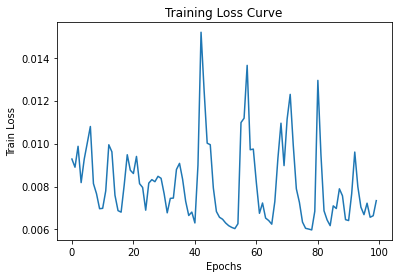

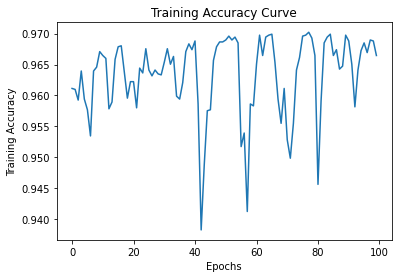

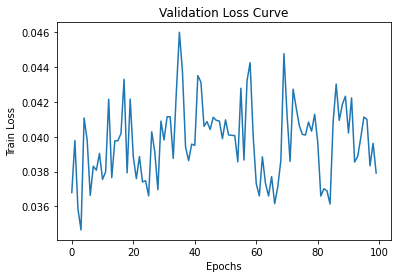

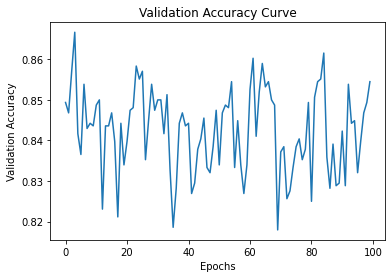

In [105]:
train_net(net= News_model,batch_size= 100,learning_rate= 0.01,num_epochs= 100,train_loader= train_loader,val_loader= val_loader,exercise_code= 'Aug_11_2_bidirectional_1_layers_hidden_size_50')

In [25]:
parameters = (50, 256, 7) # (input size, hidden size, number of classes)
model_path = get_model_path("LSTM_3", 256, 0.01, 23, "Aug_11_1_bidirectional_1_layers_hidden_size_256")
test_result = test_model(LSTM_news_classifier_3, parameters, True, model_path, test_loader, nn.MSELoss())
print("Correct: {0}\tTotal: {1}\tAccuracy: {2}\tLoss: {3}".format(test_result[0], test_result[1], test_result[2], test_result[3]))

CUDA is available!  Training on GPU ...
Correct: 1354	Total: 1560	Accuracy: 0.867948717948718	Loss: 0.033537411575133985


In [39]:
def bestTest(parameters, name, batch_size, learning_rate, num_epoch, exercise_code, net_type, criterion):
    
    results = []

    for epoch in range(num_epoch):
        
        model_path = get_model_path(name, batch_size, learning_rate, epoch, exercise_code)
        result = test_model(net_type, parameters, use_cuda, model_path, test_loader, criterion)[2]
        results.append(result)

    print('model name:',exercise_code,'best epoch is',results.index(max(results)),'test accuracy is',max(results))


In [107]:
parmeters3 = (50,122,7)

In [108]:
bestTest(parmeters3, 'LSTM_3', 244, 0.01, 100, 'Aug_11_2_bidirectional_1_layers_hidden_size_122', LSTM_news_classifier_3, nn.MSELoss())

CUDA is available!  Training on GPU ...
CUDA is available!  Training on GPU ...
CUDA is available!  Training on GPU ...
CUDA is available!  Training on GPU ...
CUDA is available!  Training on GPU ...
CUDA is available!  Training on GPU ...
CUDA is available!  Training on GPU ...
CUDA is available!  Training on GPU ...
CUDA is available!  Training on GPU ...
CUDA is available!  Training on GPU ...
CUDA is available!  Training on GPU ...
CUDA is available!  Training on GPU ...
CUDA is available!  Training on GPU ...
CUDA is available!  Training on GPU ...
CUDA is available!  Training on GPU ...
CUDA is available!  Training on GPU ...
CUDA is available!  Training on GPU ...
CUDA is available!  Training on GPU ...
CUDA is available!  Training on GPU ...
CUDA is available!  Training on GPU ...
CUDA is available!  Training on GPU ...
CUDA is available!  Training on GPU ...
CUDA is available!  Training on GPU ...
CUDA is available!  Training on GPU ...
CUDA is available!  Training on GPU ...


In [ ]:
! echo "Correct: 1323	Total: 1560	Accuracy: 0.8480769230769231	Loss: 0.03897613139870839" >> /model/test_result.txt

In [ ]:
! cp /model /content/drive/MyDrive/ -r